In [12]:
import MDAnalysis as mda #import MDAnalysis
from MDAnalysis.analysis import contacts #allows us to use contacts_within_cutoff

import os #allows us to move directories, needed for looping directories
import numpy as np #scientific computing package, for making arrays
import pandas as pd #data analysis module, for making data frames
import matplotlib.pyplot as plt #plotting module
import seaborn as sns
from math import *
##renders figures in a notebook
# %matplotlib inline 

In [13]:
plt.rcParams['figure.dpi'] = 100 #lower  quality inline figure
plt.rcParams['savefig.dpi'] = 600 #high quality save file for publication

In [14]:
rad = 3.2 #the distance within two atoms are considered to be bonded

## Azimuthal angles around the z-axis, for a total of 14 segments
thetas = ['015', '045', '075', '105', '135', '165', '195', '225', '255', '285', '315', '345',]
dcd_thetas = ['15', '45', '75', '105', '135', '165', '195', '225', '255', '285', '315', '345',]
# z values at the center of each patch, from z = -22 to z = 27 Angstrom
zz = ['-25.33', '-18.09', '-10.86', '-3.62', '03.62', '10.86', '18.09', '25.33',]

#combined z and theta values
z_theta = []
z = []
theta = []
#creating a list of all simulations and their bonds
bcolumns = ['z','theta', 'Bonds']
sb_z_theta = pd.DataFrame(columns= bcolumns)

In [15]:
#script from MDAnalysis contacts that allows us to find contacts within the cutoff 
def contacts_within_cutoff(u, acidic, basic, radius=rad):
	timeseries = []
	for ts in u.trajectory:
		dist = contacts.distance_array(acidic.positions, basic.positions)
		n_contacts = contacts.contact_matrix(dist, radius).sum()
		timeseries.append([ts.frame, n_contacts])
	return np.array(timeseries)

In [16]:
for i in range(len(zz)):
	for j in range(len(thetas)):
		## First, theta
		theta = thetas[j]
		dcd_theta = dcd_thetas[j]
		## Then z
		z = zz[i]
		#adding theta and phi to the empty theta_phi list
		z_theta.append("z = " + z + " , θ = " + theta + "°")

		#defining file locations for PSF and DCD
		PSF_loc = "configurations/" + z + "_" + theta + "/MtDARPin__T3Q_" + z + "_" + theta + "__solvated_ionized.psf"
		DCD_loc = "configurations/" + z + "_" + theta + "/o/MtDARPin__T3Q_" + z + "_" + dcd_theta + ".dcd"
		print (DCD_loc)
		#start of the MDA script
		##define a string beforehand for the filename
		##change vscode to wrap lines
		u = mda.Universe(PSF_loc,DCD_loc)
		
		sel_basic = "(resname ARG or resname LYS) and (name NE or name NZ)"
		# sel_acidic = "(resname ASP or resname GLU) and (name OD1 or name OD2 or name OE1 or name OE2)"   
		sel_acidic = "index 2405 or index 2406 or index 2409 or index 2410" #O6, O7, O9, O10 of the phosphate
		acidic = u.select_atoms(sel_acidic) 
		basic = u.select_atoms(sel_basic) 
			
		ca = contacts_within_cutoff(u, acidic, basic, radius=rad)
		ca.shape
		ca_df = pd.DataFrame(ca, columns=['Frame', '# Contacts'])
		# print dataframe
		# display(ca_df)
		
		#calculate and store the total number of bonds in the simulation
		total_sb = ca_df['# Contacts'].sum()
		# print(total_sb)

		#add the total number of bonds in an array
		#adds the theta and z values to the hbond table
		# sb_z_theta = sb_z_theta.append([{'z':z, 'theta': theta, 'Bonds': total_sb}], ignore_index=True)

		sb_z_theta_columns = pd.DataFrame([{'z':z, 'theta': theta, 'Bonds': total_sb}])
		sb_z_theta = pd.concat([sb_z_theta_columns, sb_z_theta])

		#store data frame as a text file
		sb_array = ca_df.to_numpy()
		np.savetxt("configurations/" + z + "_" + theta + "/sbridges_MDA.txt", sb_array, fmt = "%d")

		# ca_df.head()
		# ca_df.plot(x='Frame')

		# plt.savefig("configurations/figures/" + z + "_" + theta + ".png")
		# plt.ylabel('# Contacts')

		#check total number of bonds per simulation, only uncomment when troubleshooting, slows down code
		# print(sb_z_theta)

configurations/-25.33_015/o/MtDARPin__T3Q_-25.33_15.dcd
configurations/-25.33_045/o/MtDARPin__T3Q_-25.33_45.dcd
configurations/-25.33_075/o/MtDARPin__T3Q_-25.33_75.dcd
configurations/-25.33_105/o/MtDARPin__T3Q_-25.33_105.dcd
configurations/-25.33_135/o/MtDARPin__T3Q_-25.33_135.dcd
configurations/-25.33_165/o/MtDARPin__T3Q_-25.33_165.dcd
configurations/-25.33_195/o/MtDARPin__T3Q_-25.33_195.dcd
configurations/-25.33_225/o/MtDARPin__T3Q_-25.33_225.dcd
configurations/-25.33_255/o/MtDARPin__T3Q_-25.33_255.dcd
configurations/-25.33_285/o/MtDARPin__T3Q_-25.33_285.dcd
configurations/-25.33_315/o/MtDARPin__T3Q_-25.33_315.dcd
configurations/-25.33_345/o/MtDARPin__T3Q_-25.33_345.dcd
configurations/-18.09_015/o/MtDARPin__T3Q_-18.09_15.dcd
configurations/-18.09_045/o/MtDARPin__T3Q_-18.09_45.dcd
configurations/-18.09_075/o/MtDARPin__T3Q_-18.09_75.dcd
configurations/-18.09_105/o/MtDARPin__T3Q_-18.09_105.dcd
configurations/-18.09_135/o/MtDARPin__T3Q_-18.09_135.dcd
configurations/-18.09_165/o/MtDARPin_

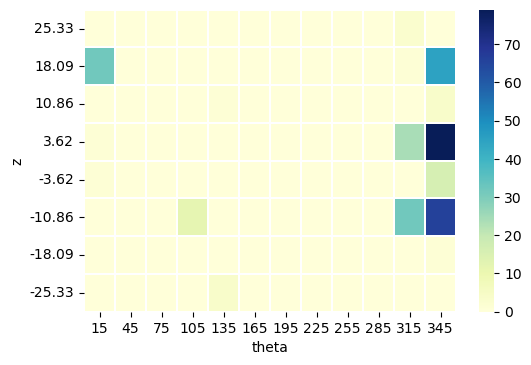

In [17]:
sb_z_theta.to_csv('00_MtDARPin_sb_phos.csv')
sb = pd.read_csv('00_MtDARPin_sb_phos.csv')


#load csv file
df_wide = sb.pivot_table( index='z', columns='theta', values='Bonds')

hm = sns.heatmap(df_wide, cmap="YlGnBu", linewidths=.003)
hm.invert_yaxis()
hm_fig = hm.get_figure() #this line may be an issue for the cluster, since there are no graphics
hm_fig.savefig("configurations/MtDARPin_sb_phos_hm.png")